In [1]:
import sys
sys.path.append('../../../GraphGallery/')
sys.path.append('../../../GraphAdv/')

import numpy as np

from graphgallery.nn.models import GCN
from graphadv.attack.untargeted import Metattack

import matplotlib.pyplot as plt

In [2]:
from graphgallery.data import NPZDataset
data = NPZDataset('citeseer', root="~/GraphData/datasets/", verbose=False, standardize=True)
adj, x, labels = data.graph.unpack()
idx_train, idx_val, idx_test = data.split(random_state=15)


Downloaded dataset files have existed.
Processing...
Processing completed.


In [12]:
idx_unlabeled = idx_test
idx_unlabeled = np.hstack([idx_val, idx_test])

In [ ]:
attacker = Metattack(adj, x, labels, 
                     idx_train, idx_unlabeled=idx_unlabeled, 
                     lr=0.01, # cora and cora_ml lr=0.1 citeseer lr=0.01
                     lambda_=1.0,
                     device="GPU", seed=None)
attacker.reset()
attacker.attack(0.25, structure_attack=True, feature_attack=False)
# show logs
attacker.show_edge_flips(detail=False)

Peturbing Graph:  82%|████████▏ | 755/917 [05:26<01:11,  2.27it/s]

In [ ]:
np.save(attacker.edge_flips, "/home/jtli/Files/WorkShop2021/adv_edges/citeseer/0.25.npy")

# Before Attack

In [ ]:
model_before = GCN(adj, x, labels, device='GPU', norm_x=None, seed=42)
model_before.build()
his_before = model_before.train(idx_train, verbose=1, epochs=100)
loss, accuracy = model_before.test(idx_test)
print(f'Test loss {loss:.5}, Test accuracy {accuracy:.2%}')

# After Attack

In [16]:
model_after = GCN(attacker.A, x, labels, device='GPU', norm_x=None, seed=42)
model_after.build()
his_after = model_after.train(idx_train, verbose=1, epochs=100)
loss, accuracy = model_after.test(idx_test)
print(f'Test loss {loss:.5}, Test accuracy {accuracy:.2%}')

<Loss = 0.1912 Acc = 1.0000 >: 100%|██████████| 100/100 [00:00<00:00, 154.15it/s]


Test loss 1.6978, Test accuracy 47.16%


In [7]:
from graphgallery.nn.models import GAT
model_after = GAT(attacker.A, x, labels, device='GPU', norm_x=None, seed=42)
model_after.build()
his_after = model_after.train(idx_train, verbose=1, epochs=200)
loss, accuracy = model_after.test(idx_test)
print(f'Test loss {loss:.5}, Test accuracy {accuracy:.2%}')

  0%|          | 0/200 [00:00<?, ?it/s]

<Loss = 0.8107 Acc = 0.8341 >: 100%|██████████| 200/200 [00:06<00:00, 51.67it/s]


Test loss 2.6319, Test accuracy 44.14%


#  Visulation

In [8]:
def plot(his_before, his_after, metric="loss"):
    with plt.style.context(['science', 'no-latex']):
        plt.plot(his_before.history[metric])
        plt.plot(his_after.history[metric])
        plt.legend([f'{metric.title()} Before', f'{metric.title()} After'])
        plt.ylabel(f'{metric.title()}')
        plt.xlabel('Epochs')
        plt.show()    

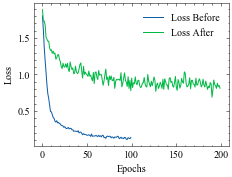

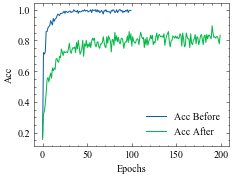

In [9]:
plot(his_before, his_after, metric="loss")
plot(his_before, his_after, metric="acc")